In [1]:
from pfs.detAnalysis import *
from pfs.detFocusAnalysis import *

from pfs.fileHandling import *
from pfs.style import *

In [2]:
imgPath = '/home/pfs/shared/Pictures/SM1/Defocus'

In [3]:
peaklist = "/home/pfs/dev/ait-notebook/optical/input/hgar_peaks_SM1_byhand.csv"
peaklist = "/home/pfs/dev/ait-notebook/optical/input/hgar_peaks_SM1_OnePeak_byhand.csv"
peaklist = "/home/pfs/dev/ait-notebook/optical/input/peaks_SM1_B1_OnePeak_WS_single.csv"
peaklist = "/home/pfs/dev/ait-notebook/optical/input/peaks_SM1_B1_OnePeak_WS_ghost.csv"

#peaklist = "/home/pfs/dev/ait-notebook/optical/input/peaks_SM1_B1_OnePeak_byhand_180K.csv"


In [131]:
roi_size = 36
com = True  # Center Of Mass
doBck = True
head = 0
tail = 0
tail_proc = 0
head_proc = 0 #3 

In [140]:
experimentId = 308

In [141]:
filelist = constructFilelist(experimentId, rerun='ginga')
filelist = filelist[head:len(filelist)-tail]

#Fiber= 1 and #peak= 1


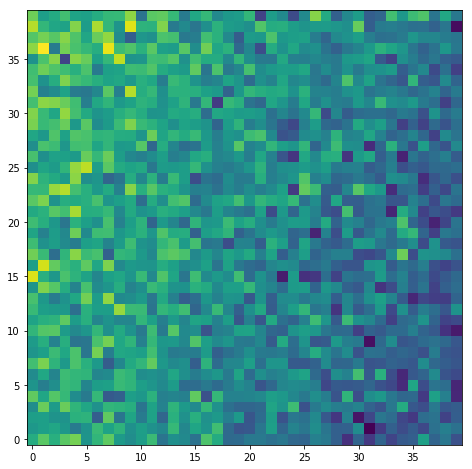

In [144]:
plotRoiPeak(filelist.filepath[15], peaklist, roi_size=40)

/software/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


#Fiber= 1 and #peak= 1


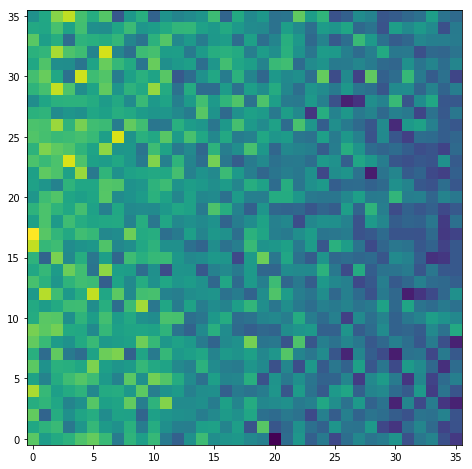

#Fiber= 1 and #peak= 1


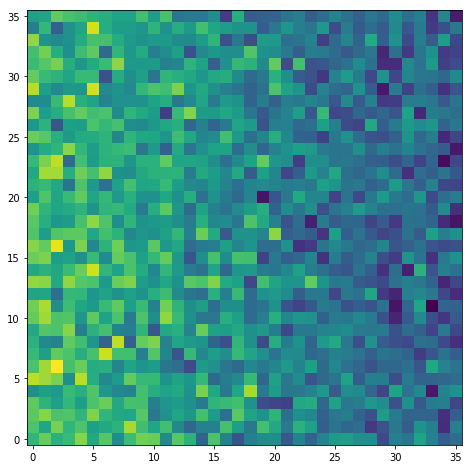

#Fiber= 1 and #peak= 1


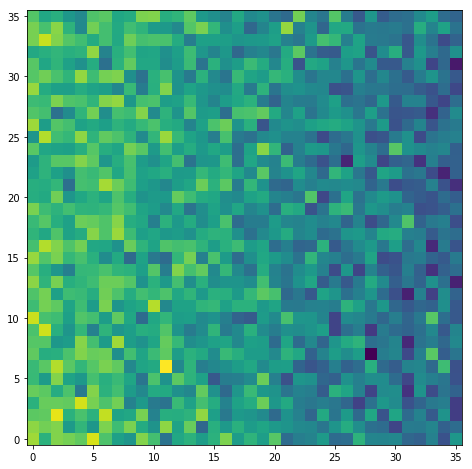

#Fiber= 1 and #peak= 1


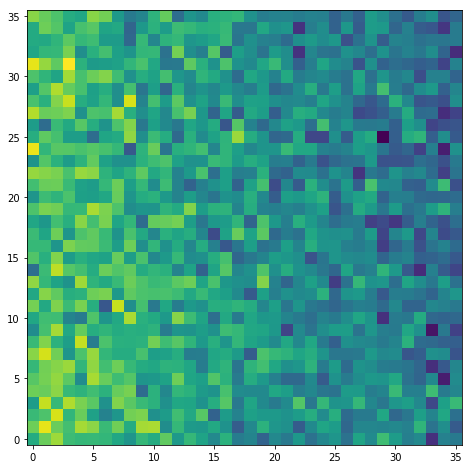

#Fiber= 1 and #peak= 1


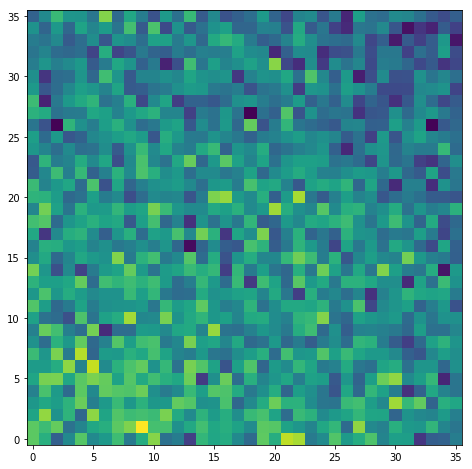

#Fiber= 1 and #peak= 1


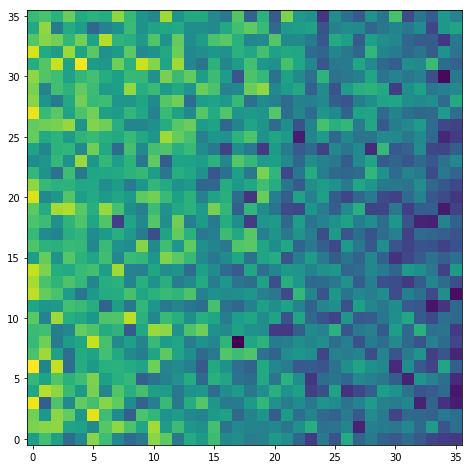

#Fiber= 1 and #peak= 1


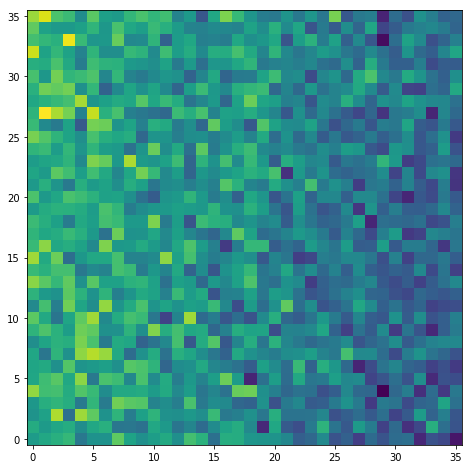

#Fiber= 1 and #peak= 1


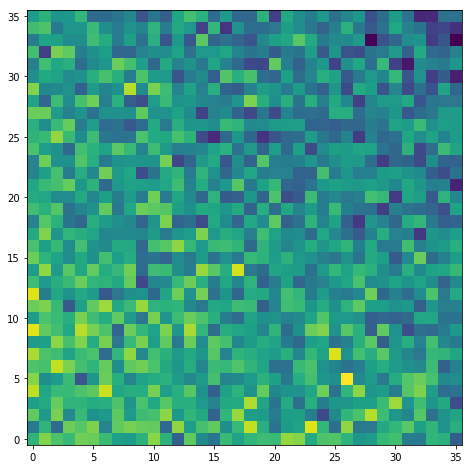

#Fiber= 1 and #peak= 1


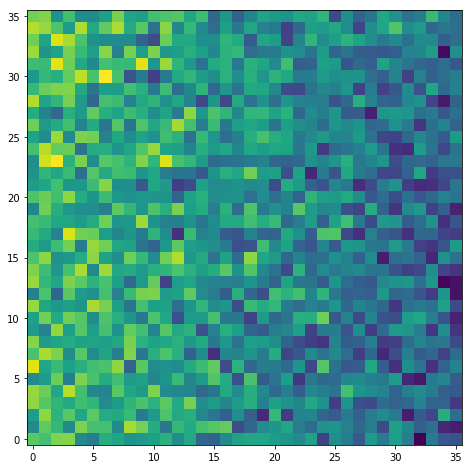

#Fiber= 1 and #peak= 1


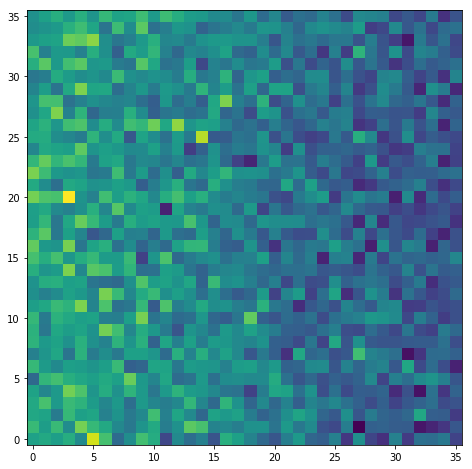

#Fiber= 1 and #peak= 1


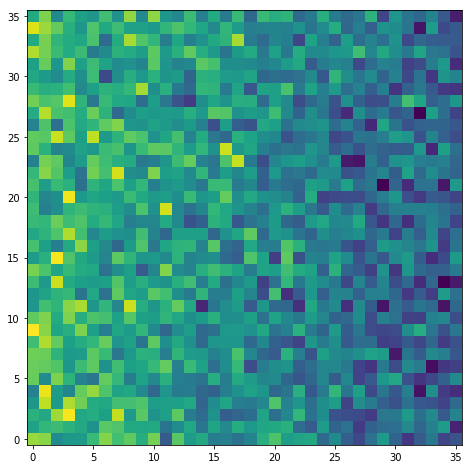

#Fiber= 1 and #peak= 1


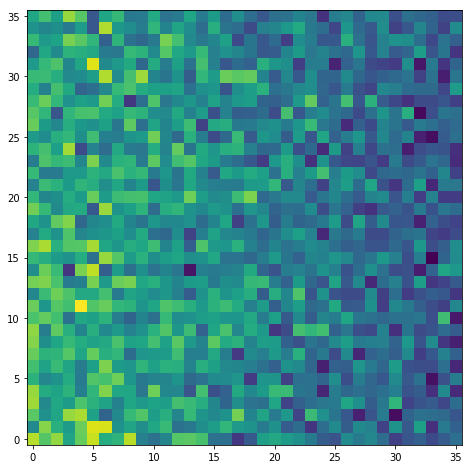

#Fiber= 1 and #peak= 1


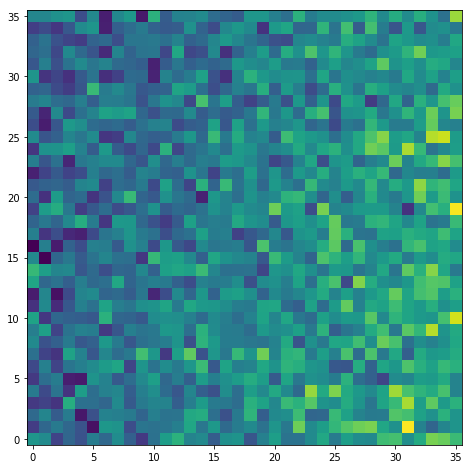

#Fiber= 1 and #peak= 1


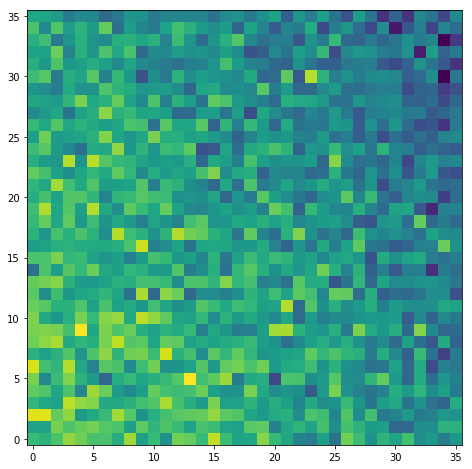

#Fiber= 1 and #peak= 1


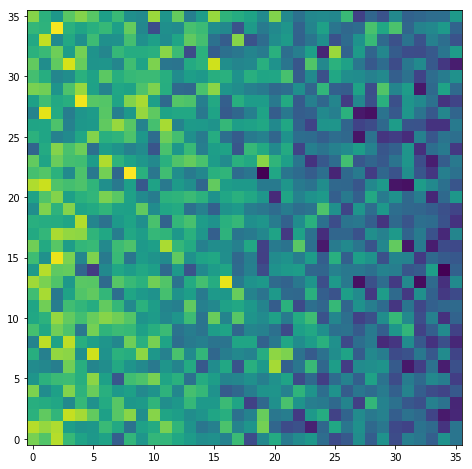

#Fiber= 1 and #peak= 1


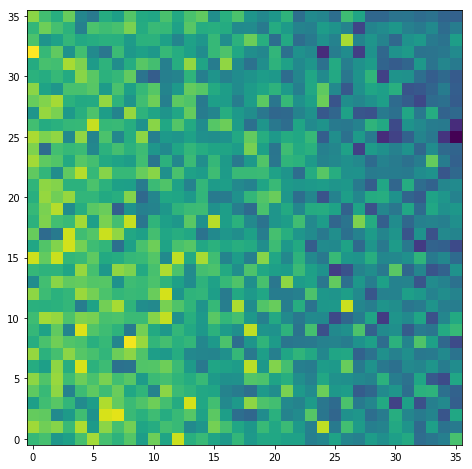

#Fiber= 1 and #peak= 1


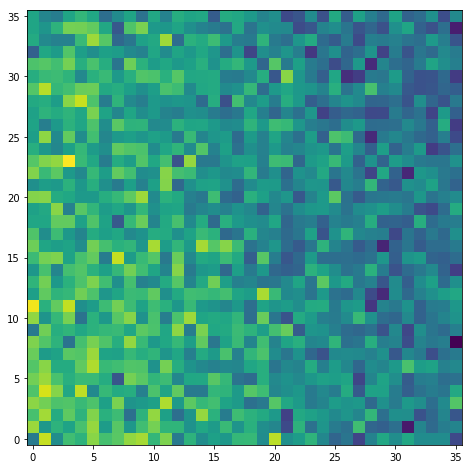

#Fiber= 1 and #peak= 1


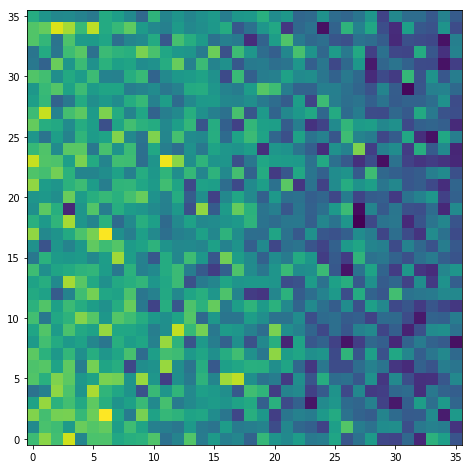

#Fiber= 1 and #peak= 1


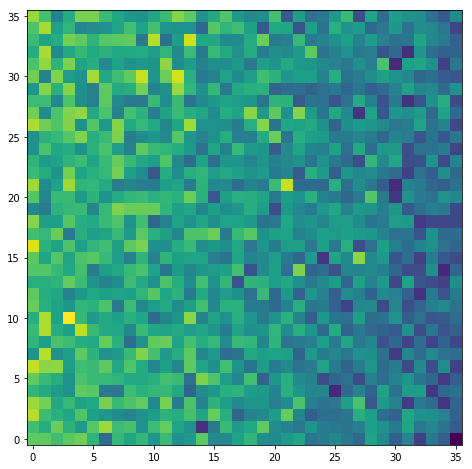

#Fiber= 1 and #peak= 1


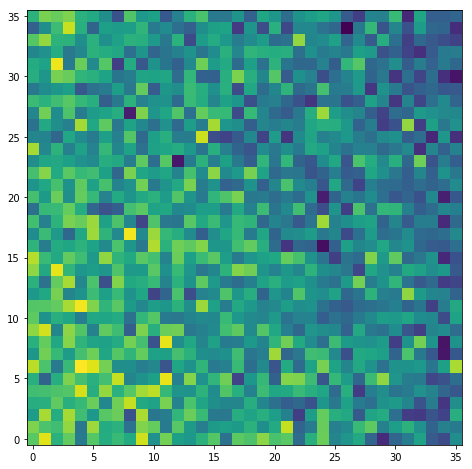

In [145]:
imdata = getAllImageQuality(filelist, peaklist,  doPlot=True, roi_size=roi_size, com=com, doBck=doBck)

In [117]:
def fitFocusData(imdata, doPlot=False, doPrint=False, head=0, tail=0):
    thfoc_data = []
    tmpdata = imdata[head:imdata.count()[0]-tail]
    
    for (peak, fiber), series in tmpdata.groupby(['peak','fiber']):
        #series = series.dropna()
        thfoc = getFocus(series, criteria='EE5', doPrint=doPrint, index="fcaFocus")
        for criteria in ['EE3', 'brightness', 'fwhm']:
            thfoc[criteria] = getFocus(series, criteria=criteria, doPrint=doPrint, index="fcaFocus")[criteria]

        thfoc['peak'] = peak
        thfoc['fiber'] = fiber
        thfoc['px'] = np.interp(thfoc['fcaFocus'], series['fcaFocus'], series['px'])
        thfoc['py'] = np.interp(thfoc['fcaFocus'], series['fcaFocus'], series['py'])

        thfoc_data.append(thfoc)

    thfoc_data = pd.concat(thfoc_data)
    
    if doPlot:
        kwargs = dict(grid=True, figsize=(14,10), legend=True, subplots=True)
        criterias = ['EE5','EE3', 'brightness', 'fwhm']
        for (peak, fiber), fit in thfoc_data.groupby(['peak','fiber']):
            raw = tmpdata.query("peak==%d and fiber==%d"%(peak, fiber))
            axes = fit.set_index('motor1')[criterias].plot(**kwargs)
            for i, criteria in enumerate(criterias):
                axes[i].plot(raw['motor1'].as_matrix(), raw[criteria].as_matrix(), 'o')
                
    return thfoc_data

In [118]:

fitdata = fitFocusData(imdata, doPlot=False, tail=tail_proc, head=head_proc)

In [119]:
fitdata = fitFocusData(imdata, doPlot=False, tail=tail_proc, head=head_proc)

In [120]:
def getFocusMap(fitdata): 
    data = []
    for (peak, fiber), series in fitdata.groupby(['peak','fiber']):
        #series = series.dropna()
        for criteria in ['EE5', 'EE3', 'brightness', 'fwhm']:
            ixmax = series[criteria].idxmin() if 'fwhm' in criteria else series[criteria].idxmax()    
            focus = series.fcaFocus[ixmax]
            px = series.px[ixmax]
            py = series.py[ixmax]
            mat = [peak,fiber,criteria, px, py, focus]
            data.append(tuple(mat))
    columns = ['peak', 'fiber', 'criteria', 'px', 'py', 'fcaFocus']
    return pd.DataFrame(data, columns=columns)

In [121]:
focusMap = getFocusMap(fitdata)

In [122]:
focusMap

,peak,fiber,criteria,px,py,fcaFocus
0,1,1,EE5,2327.056590,2473.122273,-7.827828
1,1,1,EE3,2327.056590,2473.122273,-7.827828
2,1,1,brightness,2326.132534,2472.191395,-9.796797
3,1,1,fwhm,2327.541196,2472.946017,-8.605606


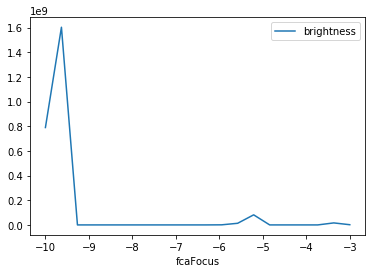

In [123]:
imdata.plot(x="fcaFocus", y="brightness")

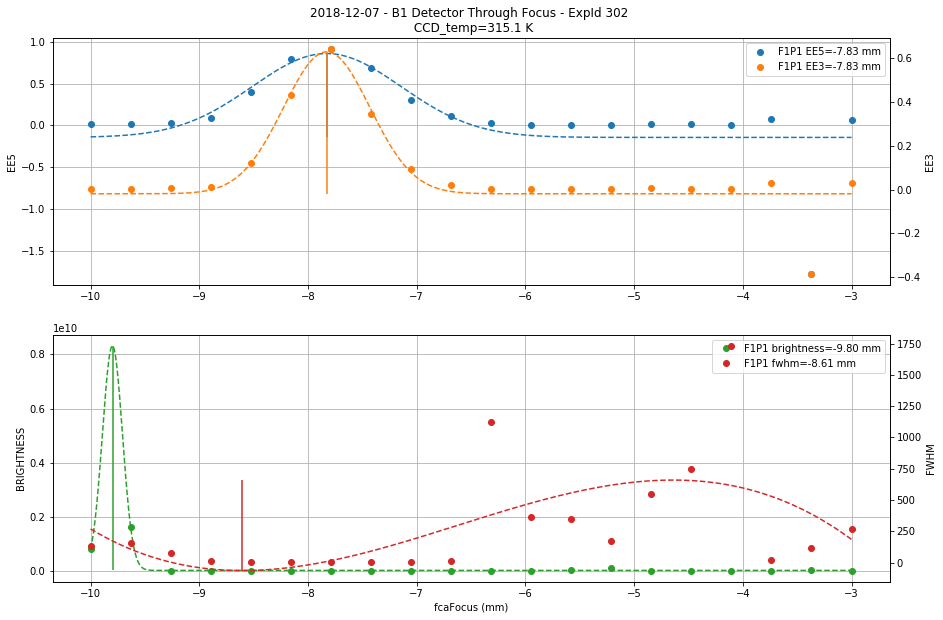

In [124]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(211)
ax2 = ax1.twinx()
ax3 = fig.add_subplot(212, sharex=ax1)
ax4 = ax3.twinx()
axes = [ax1, ax2, ax3, ax4]
lns1 = []
lns3 = []

ax1.set_title('%s - %s Detector Through Focus - ExpId %s \n CCD_temp=%.1f K'%(imdata.obsdate[0], imdata.cam[0].upper(), experimentId, imdata.ccdTemp.median()))
index = 'fcaFocus'
ax3.set_xlabel('%s (mm)'%index)
j=0

for (peak, fiber), fit in fitdata.groupby(['peak','fiber']):
    for i, criteria in enumerate(['EE5', 'EE3', 'brightness', 'fwhm']):  
        focus = focusMap.query("peak==%d and fiber==%d and criteria=='%s'"%(peak,fiber,criteria))
        raw = imdata.query("peak==%d and fiber==%d"%(peak, fiber))
        
        axes[i].plot(fit[index].as_matrix(), fit[criteria].as_matrix(), '--', color=colors[j])
        line, = axes[i].plot(raw[index].as_matrix(), raw[criteria].as_matrix(), 'o', 
                     label='F%dP%d %s=%.2f mm'%(fiber,peak,criteria,focus[index]),
                     color=colors[j])
        lns = lns1 if i in [0,1] else lns3
        lns.append(line)
        axes[i].vlines(x=focus[index], ymin=fit[criteria].min(), ymax=fit[criteria].max(), color=colors[j])                   
                        
        axes[i].set_ylabel(criteria.upper())
        j+=1

ax1.legend(lns1, [line.get_label() for line in lns1])
ax3.legend(lns3, [line.get_label() for line in lns3])

ax1.grid()
ax3.grid()

if True:
#    fig.patch.set_alpha(0.5)
    plt.savefig(os.path.join(imgPath, 'SM1_%s_ThFocus_%s_EXP%i_defocusCheck.png'%(imdata.obsdate[0],imdata.cam[0].upper(),experimentId)))
    tmpPath = "/drp/lam/rerun/fmadec/Pictures"
    plt.savefig(os.path.join(tmpPath, 'SM1_%s_ThFocus_%s_EXP%i_defocusCheck.png'%(imdata.obsdate[0],imdata.cam[0].upper(),experimentId)), transparent=False)

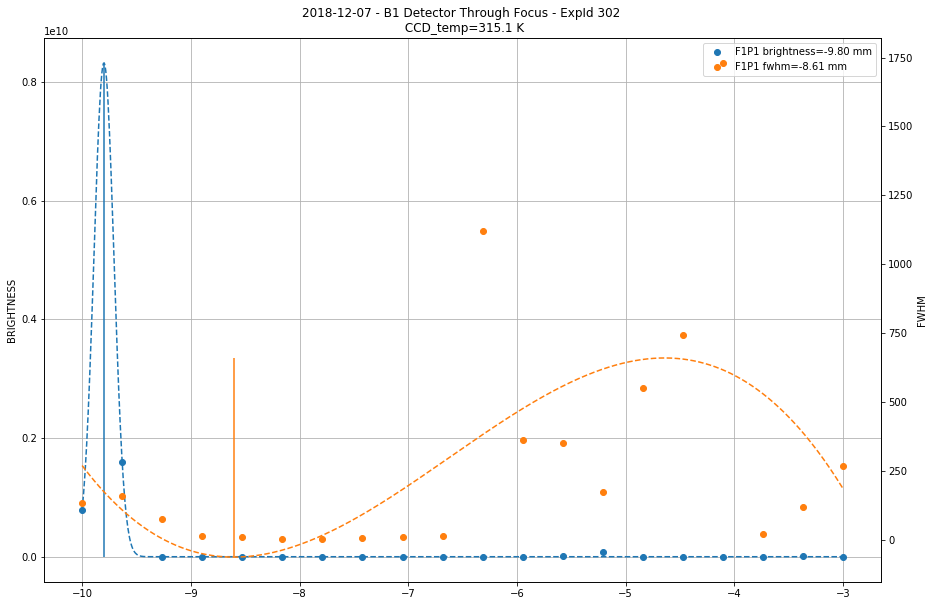

In [125]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
#ax3 = fig.add_subplot(212, sharex=ax1)
#ax4 = ax3.twinx()
axes = [ax1, ax2] #, ax3, ax4]
lns1 = []
lns3 = []

ax1.set_title('%s - %s Detector Through Focus - ExpId %s \n CCD_temp=%.1f K'%(imdata.obsdate[0], imdata.cam[0].upper(), experimentId, imdata.ccdTemp.median()))
index = 'fcaFocus'
ax3.set_xlabel('%s (mm)'%index)
j=0

for (peak, fiber), fit in fitdata.groupby(['peak','fiber']):
#    for i, criteria in enumerate(['EE5', 'EE3', 'brightness', 'fwhm']):  
    for i, criteria in enumerate(['brightness', 'fwhm']):  

        focus = focusMap.query("peak==%d and fiber==%d and criteria=='%s'"%(peak,fiber,criteria))
        raw = imdata.query("peak==%d and fiber==%d"%(peak, fiber))
        
        axes[i].plot(fit[index].as_matrix(), fit[criteria].as_matrix(), '--', color=colors[j])
        line, = axes[i].plot(raw[index].as_matrix(), raw[criteria].as_matrix(), 'o', 
                     label='F%dP%d %s=%.2f mm'%(fiber,peak,criteria,focus[index]),
                     color=colors[j])
        lns = lns1 if i in [0,1] else lns3
        lns.append(line)
        axes[i].vlines(x=focus[index], ymin=fit[criteria].min(), ymax=fit[criteria].max(), color=colors[j])                   
                        
        axes[i].set_ylabel(criteria.upper())
        j+=1

ax1.legend(lns1, [line.get_label() for line in lns1])
ax3.legend(lns3, [line.get_label() for line in lns3])

#ax1.set_ylim(0,10000)
#ax2.set_ylim(0,50)

ax1.grid()
ax3.grid()

if True:
#    fig.patch.set_alpha(0.5)
    plt.savefig(os.path.join(imgPath, 'SM1_%s_ThFocus_%s_EXP%i_defocusCheck_brigth.png'%(imdata.obsdate[0],imdata.cam[0].upper(),experimentId)))
    tmpPath = "/drp/lam/rerun/fmadec/Pictures"
    plt.savefig(os.path.join(tmpPath, 'SM1_%s_ThFocus_%s_EXP%i_defocusCheck_brigth.png'%(imdata.obsdate[0],imdata.cam[0].upper(),experimentId)), transparent=False)